# Basic pipeline

**Noam Gini 208375642  
Shai Fisher 315150342**

## Flight fares predictions using the following dataset: [Filght fares](https://www.kaggle.com/datasets/yashdharme36/airfare-ml-predicting-flight-fares)

### Imports of relevant packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

## Introducing the Flight fares dataset - Exploratory Data Analysis (EDA)

In [2]:
dtf = pd.read_csv("./data/data_airfare.csv")

In [3]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
categorical_columns = [c for c in dtf.columns if c not in numeric_columns]

In [4]:
cols = ["Date_of_journey","Journey_day","Airline","Flight_code","Class",
        "Source","Departure","Total_stops","Arrival","Destination",
        "Duration_in_hours", "Days_left", "Fare"]
dtf = dtf[cols]

**Let's take a look at the data**

In [5]:
dtf.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.3333,1,5899
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.1667,1,5801
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5794
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.1667,1,5955


In [6]:
dtf.describe()

,Duration_in_hours,Days_left,Fare
count,452088.000000,452088.000000,452088.000000
mean,12.349222,25.627902,22840.100890
std,7.431478,14.300846,20307.963002
min,0.750000,1.000000,1307.000000
25%,6.583300,13.000000,8762.750000
50%,11.333300,26.000000,13407.000000
75%,16.500000,38.000000,35587.000000
max,43.583300,50.000000,143019.000000


**Note:** The Fare of the flight tickets is in INR  
**1 USD = 82.78 INR**

**Examining the target feature - "Fare" Using Histogram, a KDE plot, and a Box plot**

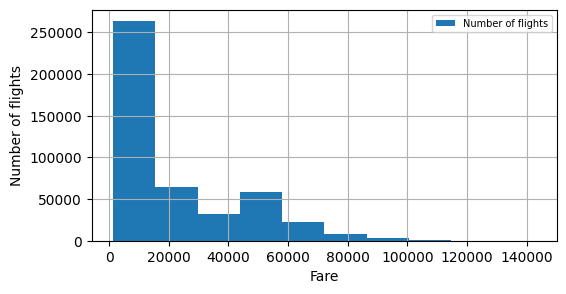

In [7]:
plt.figure(figsize=(6, 3))
dtf.Fare.hist(label = 'Number of flights')
plt.xlabel('Fare')
plt.ylabel('Number of flights')
plt.legend(prop={'size': 7})
plt.show()

Exploring the tickets fare:
From the description table above the histogram, we learn that the minimum ticket fare is 1,307 INR and maximum is 143,019 INR. There exists a difference in mean and median values as well.  

Let's examine the outliers with box plot.

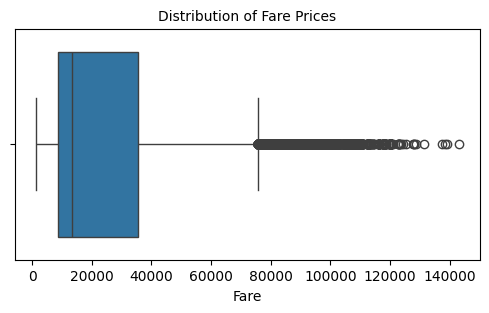

In [8]:
plt.figure(figsize=(6, 3))
sns.boxplot(dtf.Fare, orient="h")
plt.title("Distribution of Fare Prices", fontsize=10)
plt.show()

A Fare outlier is acceptable because there are different ticket classes - Economy, Premium Economy, Business and First class.
Even though the mean is around 20000, we can see that the median is approximately 14000.
In the KDE plot, we can see that the dispersion seems to be composed by two gaussian curves.
The first one - From 1,000 to 30,000 there is one peak, corresponding to the cheap tickets 
The second one - A peak from 40,000 to 80,000 corresponding to the expensive classes tickets.
We have decided not to remove the fare outliers for now.

## Cleaning and Preprocessing

We will make sure that there are no null values in our data

In [9]:
if dtf.isnull().sum().sum() == 0:
    print("No null values found.")

No null values found.


Now we will check for duplicates in our data

In [10]:
print(dtf.duplicated().sum())
dtf = dtf.drop_duplicates()

6722


There were 6722 duplicated rows and we removed them.

Changing the 'Days_left' feature name to a more indicitive one

In [11]:
dtf.rename(columns={'Days_left': 'Advance_days'}, inplace=True)

We will check the format and uniqueness of the 'Arrival' and 'Departure' values

In [12]:
print(dtf['Departure'].unique())
print(dtf['Arrival'].unique())

['After 6 PM' 'Before 6 AM' '12 PM - 6 PM' '6 AM - 12 PM']
['After 6 PM' 'Before 6 AM' '6 AM - 12 PM' '12 PM - 6 PM']


We will change the naming conventions for the 'Arrival' and 'Departure' fields

In [13]:
def map_departure_time_range(departure_time):
    if 'Before 6 AM' in departure_time:
        return 'Early morning'
    elif '6 AM - 12 PM' in departure_time:
        return 'morning'
    elif '12 PM - 6 PM' in departure_time:
        return 'noon'
    else:
        return 'night'

dtf['Departure'] = dtf['Departure'].apply(map_departure_time_range)
dtf['Arrival'] = dtf['Arrival'].apply(map_departure_time_range)
dtf.head(2)

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Advance_days,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,night,non-stop,night,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,night,non-stop,Early morning,Mumbai,2.3333,1,5899


We will add a new feature called 'Month' so we can see the relation of flights amount to the travel's month

In [14]:
dtf['Date_of_journey'] = pd.to_datetime(dtf['Date_of_journey'])
dtf['Month'] = dtf['Date_of_journey'].dt.month

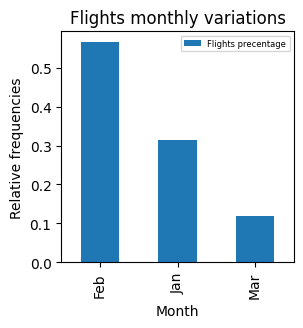

In [15]:
Month_ = pd.to_datetime(dtf.Date_of_journey.values).month
pd.Series(Month_.value_counts(normalize = True).values,index=["Feb","Jan","Mar"]).\
    plot(kind = 'bar', title="Flights monthly variations",  figsize=[3, 3], xlabel = "Month", ylabel = "Relative frequencies", label = "Flights precentage")
plt.legend(prop={'size': 6})
plt.show()

We can see that Feburary is a busy month in flights, this might be because February often marks the end of winter and the beginning of spring in many parts of India. This transition period might witness increased travel activities due to favorable weather conditions, leading to more flights.

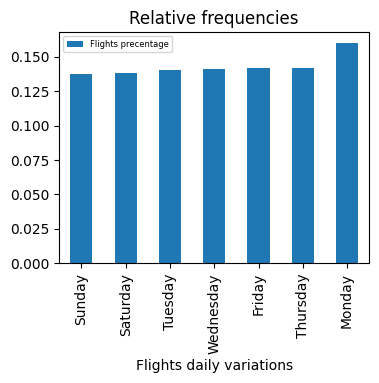

In [16]:
plt.figure(figsize=(4, 3))
dtf.Journey_day.value_counts(normalize = True, ascending = True).plot(kind="bar",
 title = "Relative frequencies",xlabel = "Flights daily variations", label = "Flights precentage")
plt.legend(prop={'size': 6})
plt.show()

We can see that the precentage of the flights is pretty similar for all the days, except Monday.
we would expect that there will be a significant difference between the number of flights during the weekend and the weekdays.

### todo - maybe remove comment
To ensure that our training and test sets accurately represent the daily variations observed in the dataset, where flights are evenly distributed across all seven weekdays, we will employ a stratified split based on this feature during the data partitioning process. This approach will help maintain the proportional representation of each weekday's frequencies in both the training and test sets.

### Visualization

Now we will take a look at the Histogram for each categorical attribute

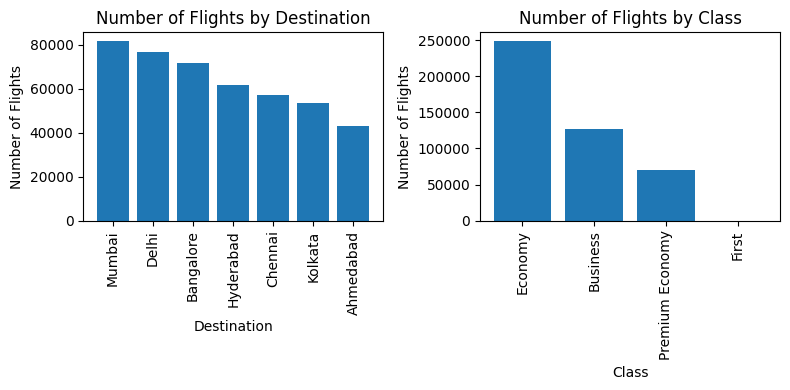

In [17]:
features = ['Destination', 'Class'] 
fig, axes = plt.subplots(1, len(features), figsize=(8, 4))
 
for i, feature in enumerate(features):
    feature_counts = dtf[feature].value_counts()
    axes[i].bar(feature_counts.index, feature_counts.values)
    axes[i].set_title(f'Number of Flights by {feature.capitalize()}')
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel('Number of Flights')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Now, let's examine a Violin plot showcasing the fare distribution for each class

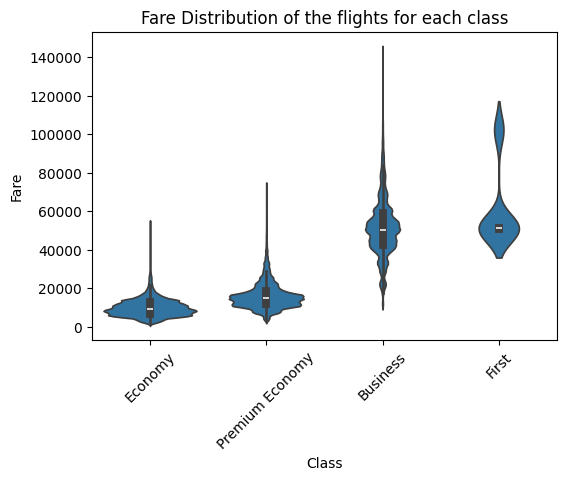

In [18]:
plt.figure(figsize=(6,4))
sns.violinplot(x='Class', y='Fare', data=dtf)
plt.title('Fare Distribution of the flights for each class')
plt.xlabel('Class')
plt.ylabel('Fare')
plt.xticks(rotation=45)
plt.show()

Using the Violin plot, we can gain insights into the distribution of flight fares across different class types:
- Economy class has an average fare of 10,000 INR, with the majority of listings falling between 5,000 INR and 15,000 INR.
- Premium Economy class has an average fare of 15,000 INR, with the majority of listings ranging from 10,000 INR to 20,000 INR.
- Business class has an average fare of 50,000 INR, with most listings falling between 40,000 INR and 60,000 INR.
- First class has an average fare of 50,000 INR, with the majority of listings between 45,000 INR and 55,000 INR. Additionally, there is another peak around 100,000 INR.
  
It's evident that Business and First class tickets are more expensive compared to Economy and Premium Economy, as expected.

### Converting categorial attributes to numeric values

In [19]:
# Create a copy of the original DataFrame to preserve original attributes for future usage
original_dtf = dtf.copy()

In [20]:
day_mapping = {'Sunday': 1,'Monday': 2,'Tuesday': 3,'Wednesday': 4,'Thursday': 5,'Friday': 6,'Saturday': 7}
dtf['Journey_day'] = dtf['Journey_day'].map(day_mapping)

class_mapping = {'Economy': 1,'Premium Economy': 2,'Business': 3,'First': 4}
dtf['Class'] = dtf['Class'].map(class_mapping)

stop_mapping = {'non-stop': 0,'1-stop': 1,'2+-stop': 2}
dtf['Total_stops'] = dtf['Total_stops'].map(stop_mapping)

In [21]:
from sklearn.preprocessing import LabelEncoder

def encoder_func(dtf,features,embed):
    dtf['Date_of_journey'] = pd.to_datetime(dtf['Date_of_journey'])
    min_date = dtf['Date_of_journey'].min()
    dtf['Date_of_journey'] = ((dtf['Date_of_journey'] - min_date).dt.total_seconds() / (24 * 60 * 60)).astype(np.int32)

    label_encoder = LabelEncoder()
    if embed == 1:
        le_dict={}
        for col in features:
            dtf[col] = label_encoder.fit_transform(dtf[col])
            le_dict[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        return dtf, le_dict
        
    for col in features:
            dtf[col] = label_encoder.fit_transform(dtf[col])
    return dtf

In [22]:
features =['Airline', 'Flight_code', 'Source', 'Departure', 'Arrival', 'Destination']
dtf = encoder_func(dtf,features,0)

In [23]:
# dtf['Date_of_journey'] = pd.to_datetime(dtf['Date_of_journey'])
# min_date = dtf['Date_of_journey'].min()

# # Convert the dates to numeric values representing elapsed time in days
# dtf['Date_of_journey_numeric'] = ((dtf['Date_of_journey'] - min_date).dt.total_seconds() / (24 * 60 * 60)).astype(np.int32)



**Date_of_journey ----> Date_of_journey_numeric**  
Our data is between 16/01/2023 and 06/03/2023 therefore we converted the dates in the following format:  
16/01/2023 ----> 0  
17/01/2023 ----> 1  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.  
06/03/2023 ----> 49  

Converting all the other categorial attributes by a LabelEncoder

In [24]:
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# for col in ['Airline', 'Flight_code', 'Source', 'Departure', 'Arrival', 'Destination']:
#     dtf[col] = label_encoder.fit_transform(dtf[col])

# # Drop original datetime columns
# dtf.drop(columns=['Date_of_journey', 'Journey_day'], inplace=True)

### Examining Correlations to the target feature

<Axes: >

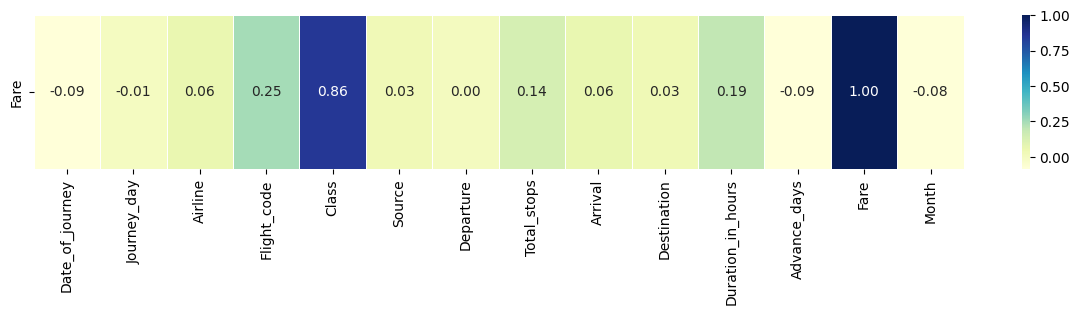

In [25]:
columns = dtf.select_dtypes(include=np.number).columns.tolist()
columns = dtf[columns]
dtf_corr = columns.corr(method="pearson").loc[["Fare"]]
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)

We observe a significant correlation between the flight Fare and the 'Class' feature.

## Baseline Model

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

We will split the data to test and training sets with stratified method based on the daily variation of flights with shaffle before split.

Creating a statistics measurements function that we will use to measure our models accurcy 

In [27]:
def statistics_measurements(model_name,y_test,y_pred):
    print(model_name)
    print("R2 Score:", r2_score(y_test, y_pred))
    print("Mean Absolute Perc Error:","{:,.3f}".format(mean_absolute_percentage_error(y_test,y_pred)))

In [28]:
X = dtf.drop(columns = 'Fare')
y = dtf.Fare

X_train_bm, X_test_bm, y_train_bm, y_test_bm = train_test_split(X,y, test_size=0.2, stratify=dtf["Journey_day"], random_state=42, shuffle = True)
baseline_model = xgb.XGBRegressor(objective="reg:squarederror")
baseline_model.fit(X_train_bm, y_train_bm)

y_pred_bm = baseline_model.predict(X_test_bm)
statistics_measurements('baseline_model',y_test_bm,y_pred_bm)
residuals = y_test_bm - y_pred_bm

baseline_model
R2 Score: 0.9489107930030836
Mean Absolute Perc Error: 0.141


A R-squared (R²) score of 0.9489 indicates that approximately 94.89% of the variance in the dependent variable (target variable) is explained by the independent variables (predictors) in your regression model.

We now plot the true values against the predicted values.

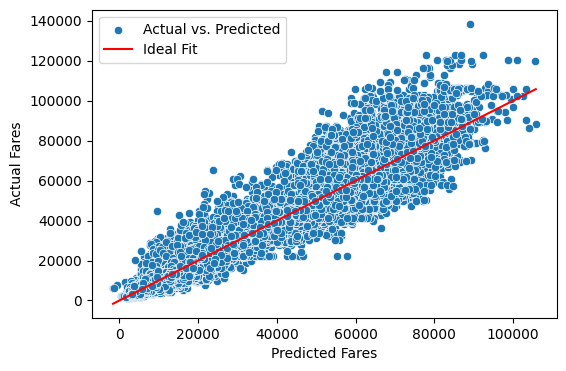

In [29]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=y_pred_bm,y=y_test_bm,ax=ax, label='Actual vs. Predicted')
sns.lineplot(x=y_pred_bm,y=y_pred_bm,ax=ax,color='red', label='Ideal Fit')
ax.set_xlabel('Predicted Fares')
ax.set_ylabel('Actual Fares')
ax.legend()
plt.show()

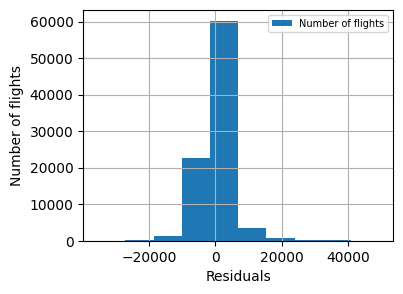

In [30]:
plt.figure(figsize=(4,3))
residuals.hist(label = 'Number of flights')
plt.xlabel('Residuals')
plt.ylabel('Number of flights')
plt.legend(prop={'size': 7})
plt.show()

We can see the residuals distribution is centered around 0.

### Results

The baseline model has a Mean Absolute Error of 2,697 and an R2 score of ~0.9489, which looks a good fit for our model.  
The regression plot shows that the predicted fares are close to the actual fares, and the residuals distribution plot shows that the residuals are normally distributed around 0.

## Improving The Base Model

The accuracy of our baseline model is good, however, we would like to investigate several approaches to enhance its performance further.

First, we would like to analyze the predictions using the SHAP library, a tool commonly used for interpreting machine learning models. Therefore, we'll sample the top overpredicted and underpredicted instances. By doing so, we aim to discern patterns and underlying factors contributing to these predicted outliers.

We chose to take less then 2% of our entire data instances - we will use 1000 outlier samples in the following steps

In [31]:
def get_outliers(num_of_outliers, dtf, y_pred, y_test):
    fare_difference = y_pred - y_test
    sorted_fare_difference = fare_difference.sort_values(ascending=False)
    
    over_predicted_indices = sorted_fare_difference.index[:num_of_outliers]
    under_predicted_indices = sorted_fare_difference.index[-num_of_outliers:]
    
    return over_predicted_indices,under_predicted_indices

In [32]:
num_of_outliers = 1000
top_over_predicted_indices, top_under_predicted_indices = get_outliers(num_of_outliers,dtf,y_pred_bm,y_test_bm)
top_over_predicted_samples = dtf.loc[top_over_predicted_indices].drop(columns=['Fare'])
top_under_predicted_samples = dtf.loc[top_under_predicted_indices].drop(columns=['Fare'])

## SHAP Analysis

In [33]:
import shap

explainer = shap.TreeExplainer(baseline_model)
shap_values_over_predicted = explainer(top_over_predicted_samples)
shap_values_under_predicted = explainer(top_under_predicted_samples)

C:\Users\Noam\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Visualize SHAP summary plot for top over-predicted samples

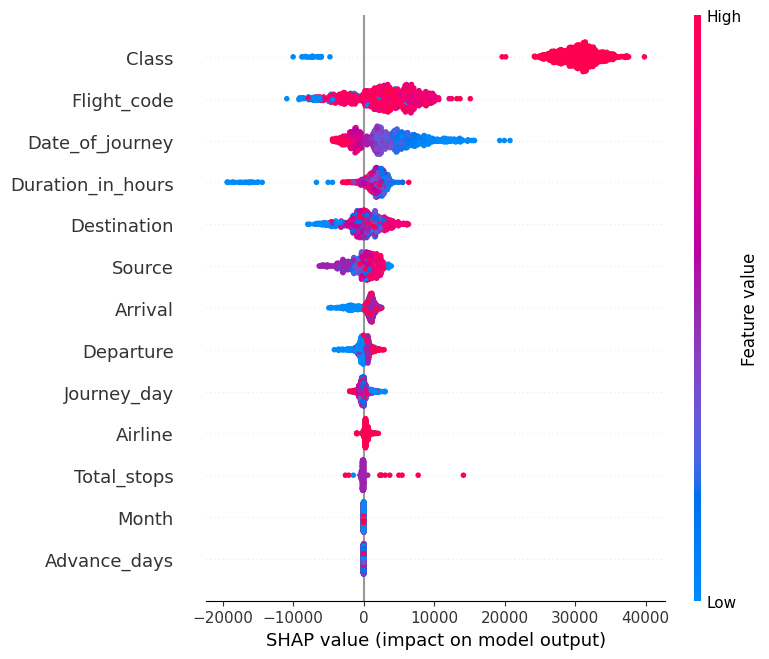

In [34]:
shap.summary_plot(shap_values_over_predicted, features=top_over_predicted_samples, title="SHAP Summary Plot - Top Over-predicted Samples")

Note: We ran the plot also for the underpredicted shap values and got a similar result so we present just the overpredicted plot. 

Both plots illustrate the effect of the different features on predictions. Samples further away from the zero line indicate a stronger negative or positive effect on price predictions. For instance, in the 'class' feature, "low" blue dots (representing economy class) are associated with lower predicted prices than actual prices, while "high" red dots (representing first class) are associated with higher predicted prices than actual prices.
We can also see that in the 'Advance_days' feature, we observe an inverse relationship: higher values (indicating booking the flight well in advance) correspond to lower predicted prices, and conversely, lower values correspond to higher predicted prices.

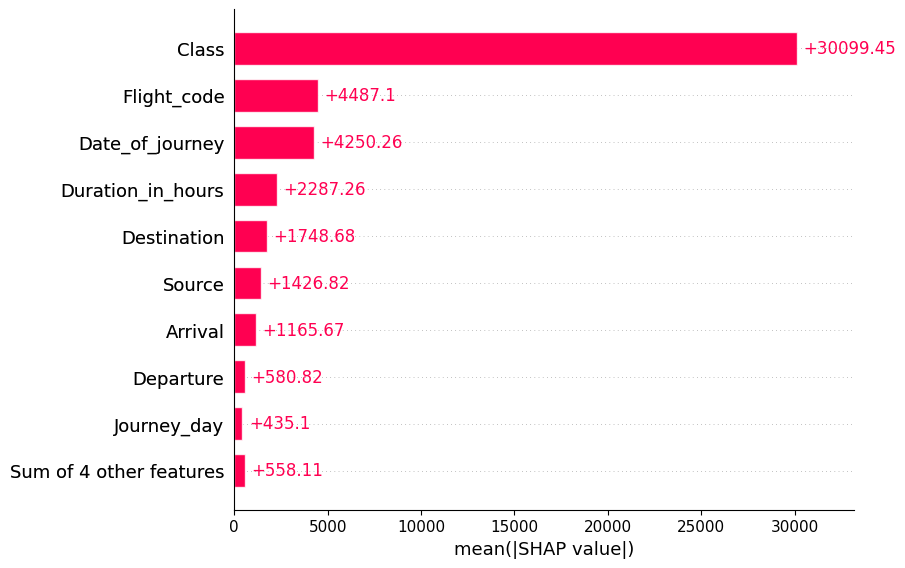

In [83]:
shap.plots.bar(shap_values_over_predicted)

Note: We ran the bar plot also for the underpredicted shap values and got a similar result so we present just the overpredicted plot. 

### SHAP Conclusions

Note: We conducted SHAP analysis on the entire dataset as well, although we didn't include it, in order to reduce  the number of plots.
However, we'll utilize insights from the entire dataset analysis to draw conclusions.
To summarize briefly, the 'class' feature has the most significant influence on the predictions. Additionally, 'duration_in_hours' and 'advance_days' have a similar effects on the predictions, (smaller gaps between them then the ones shown on the above bar plot).
Moreover, there's a difference in the influence of the 'source' feature, where in the above plot a larger effect is shown.

After running SHAP on the overpredicted and underpredicted samples, we got to a few interesting conclusions:
- We can see that the most influence on the over/under predicted instances is the Class feature, note that we also noticed that it has the most influence on the predictions of the entire data, so it fits our expectations - we will want to explore this feature later on.
- In the source feature we saw a small difference between the influence of it on the entire data predictions, where in the top 1000 over/under predicted instances we saw it had a larger effect, and it suits our suspicions regarding the amount of occurences of Delhi in our 1000 over/under predicted instances
- In the duration_in_hours feature has influence on the over/under predicted instances. We can see that "low" blue dots (representing shorter flight duration) are associated with lower predicted prices than actual prices, as expected.

## Feature engineering

 ### Binning

We saw that 'advanced_days' has a significant influence on the predictions so we will try to divide 'advanced_days' feature into bins and check the model accuracy results

We created 3 bins:  
0: 0-14 days  
1: 14-28 days  
2: 28+ days

In [36]:
bins = [0, 14, 28, float('inf')]
labels = [0, 1, 2]
data= dtf.copy()

data['Advance_days_bin'] = pd.cut(data['Advance_days'], bins=bins, labels=False, right=True)
data = data.drop(columns=['Advance_days'])
data['Advance_days_bin'] = data['Advance_days_bin'].astype(int)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=data["Journey_day"], random_state=42, shuffle = True)
bin_model = xgb.XGBRegressor(objective="reg:squarederror")
bin_model.fit(X_train, y_train)

y_pred = bin_model.predict(X_test)
statistics_measurements('bin_model',y_test,y_pred)

bin_model
R2 Score: 0.9489107930030836
Mean Absolute Perc Error: 0.141


It appears that the model accuracy remains the same.

Next, we will try to remove the outliers and see if there is an improvment in the accuracy of the model

### Removing Outliers

In [38]:
dtf_copy = dtf.copy()

In [39]:
dtf_copy = dtf_copy.drop(index=top_over_predicted_indices)
dtf_copy = dtf_copy.drop(index=top_under_predicted_indices)

In [40]:
X = dtf_copy.drop(columns = 'Fare')
y = dtf_copy.Fare

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=dtf_copy["Journey_day"], random_state=42, shuffle = True)

In [41]:
baseline_model_rm_outliers = xgb.XGBRegressor(objective="reg:squarederror")
baseline_model_rm_outliers.fit(X_train, y_train)

y_pred = baseline_model_rm_outliers.predict(X_test)
statistics_measurements('baseline_model_rm_outliers:',y_test,y_pred)

baseline_model_rm_outliers:
R2 Score: 0.9516348211016281
Mean Absolute Perc Error: 0.138


We can see some improvement in the model accuracy

## 'Class' Feature punish - todo : change title

Now, we will want to take a look at the 'Class' feature that has the most significant influence on the prediction as we saw above in the SHAP analysis

In [42]:
dtf['Class'].value_counts()

Class
1    248323
3    126535
2     70364
4       144
Name: count, dtype: int64

We will take a look of the 'Class' feature of the over/under predicted samples to see which class occures the most

In [43]:
print(f"Counts of class in the top 1000 over-predicted samples:\n{top_over_predicted_samples['Class'].value_counts().to_string()}\n")
print(f"Counts of class in the top 1000 under-predicted samples:\n{top_under_predicted_samples['Class'].value_counts().to_string()}")

Counts of class in the top 1000 over-predicted samples:
Class
3    979
2     21

Counts of class in the top 1000 under-predicted samples:
Class
3    907
2     53
1     40


We can see that a majority of over/under predicted instances have 'Class'= 3 (Business Class), we will use penalizing on 'Class' feature accordingly

We want to see the MAE of 'Class'= 3 in the baseline model, and see if it is improved after punishing the different classes 

In [44]:
indices_class3 = (X_test_bm['Class'] == 3)
y_pred_class3 = y_pred_bm[indices_class3]
y_test_class3 = y_test_bm[indices_class3]

mae_class3 = mean_absolute_error(y_test_class3, y_pred_class3)
print("MAE for Class 3:", mae_class3)

MAE for Class 3: 5104.581541600475


In [45]:
# Define punishment weights based on class values
class_punishment = {1: 1, 2: 2, 3: 2, 4: 1}
sample_weights_train = np.array([class_punishment.get(c, 1) for c in X_train_bm["Class"]])

weighted_model = xgb.XGBRegressor(objective="reg:squarederror")
weighted_model.fit(X_train_bm, y_train_bm, sample_weight=sample_weights_train)

y_pred = weighted_model.predict(X_test_bm)
statistics_measurements('weighted_model:',y_test_bm, y_pred)

weighted_model:
R2 Score: 0.950055063072105
Mean Absolute Perc Error: 0.145


We observe a little improvement

We also can see that the mean absolute error decreased

In [46]:
indices_class3 = (X_test_bm['Class'] == 3)
y_pred_class3 = y_pred[indices_class3]
y_test_class3 = y_test_bm[indices_class3]

mae_class3 = mean_absolute_error(y_test_class3, y_pred_class3)
print("MAE for Class 3:", mae_class3)

MAE for Class 3: 4996.679881679337


We want to try to train the model with applying logarithmic function on the target values, and maybe add some hyperparameters to improve the basline model accuracy

### Parameters Tuning

We measured the model with various hyperparameters to improve the model performance.
By tuning these hyperparameters, we aim to improve the model's ability to generalize to new, unseen data.
The hyperparameters we selected for optimization are as follows:
- Learning rate - controls how much we adjust our model in response to the error it made during training. A smaller learning rate means we make smaller adjustments, while a larger one means bigger adjustments, impacting how quickly the model learns.
- Max Depth - determines how deep our decision trees can grow during training. A deeper tree can capture more complex patterns in the data but may also lead to overfitting if not carefully controlled.
- Reg Lambda (Regularization Lambda) - Reg Lambda is a regularization parameter that helps prevent overfitting by penalizing large coefficients in the model. Higher values of Reg Lambda result in stronger regularization, limiting the complexity of the model.
- Min Child Weight - This parameter specifies the minimum sum of instance weight needed in a child. It is used to control overfitting by preventing the algorithm from learning relationships that are highly specific to the particular sample. Higher values of min_child_weight lead to a more conservative algorithm, which may prevent overfitting but could also risk underfitting if set too high.
- Subsample - This parameter specifies the fraction of samples (observations) to be randomly selected for each tree. It adds randomness into the training process and helps prevent overfitting. By training each tree on a subset of the data, the model can learn to generalize better to unseen data.

We conducted a hyperparameter search to optimize the performance of our XGBoost regression model. Hyperparameters are parameters that are not directly learned during the training process but rather control the learning process itself. By tuning these hyperparameters, we aim to improve the model's ability to generalize to new, unseen data.

In [47]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

def improve_params(X_train_bm,y_train_bm):
    # Define hyperparameter search space
    hyperparameters = {
        'learning_rate': uniform(0.001, 0.2),
        'max_depth': randint(3, 15),
        'min_child_weight': randint(1, 10),
        'subsample': [0.5, 0.8, 1.0],
        'reg_lambda': uniform(0, 1)
    }
    
    search = RandomizedSearchCV(estimator=baseline_model, param_distributions=hyperparameters, n_iter=20, cv=5, verbose=2, random_state=42, n_jobs=-1)
    search.fit(X_train_bm, y_train_bm)
    
    best_params = search.best_params_
    return best_params


We used the fucntion to determine the best params values for getting the best prediction model.  
best params = {'learning_rate': 0.17100771555795988, 'max_depth': 14, 'min_child_weight': 2, 'reg_lambda': 0.09541011649041131, 'subsample': 1.0}

Now, let's run the model with the params we recieved

In [48]:
best_params = {'learning_rate': 0.17100771555795988, 'min_child_weight': 2,'max_depth': 14, 'reg_lambda': 0.09541011649041131, 'subsample': 1.0}

param_model = xgb.XGBRegressor(objective="reg:squarederror", **best_params)

param_model.fit(X_train_bm, y_train_bm)
y_pred = param_model.predict(X_test_bm)
statistics_measurements('param_model:',y_test_bm,y_pred)

param_model:
R2 Score: 0.9724991050725552
Mean Absolute Perc Error: 0.083


We observe a significat improve in the model's accuracy

### Log-Transformed Fare

Now we will try applying a logarithmic transformation to the target variable (Fare) in order to normalize its distribution before training an XGBoost regression model to predict Fare values more effectively.

In [49]:
X = dtf.drop(columns = 'Fare')
y = dtf.Fare
y_log = np.cbrt(y)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X,y_log, test_size=0.2, stratify=dtf["Journey_day"], random_state=42, shuffle = True)

baseline_model_log = xgb.XGBRegressor(objective="reg:squarederror")
baseline_model_log.fit(X_train_log, y_train_log)
y_pred = baseline_model_log.predict(X_test_log)
statistics_measurements('baseline_model_log',y_test_log,y_pred)

baseline_model_log
R2 Score: 0.9596812658630266
Mean Absolute Perc Error: 0.043


We can see an improvement from the baseline model

## Combining 'Class' Feature punish, Parameters Tuning and Log-Transformed Fare

Now we will combine 'Class' Feature punish, Parameters Tuning and Log-Transformed Fare, in order to see if the model retrieves better predictions


In [50]:
# Define punishment weights based on class values
class_punishment = {1:1 ,2: 2, 3: 2, 4:1}
sample_weights_train = np.array([class_punishment.get(c, 1) for c in X_train_log["Class"]])

combined_model = xgb.XGBRegressor(objective="reg:squarederror", **best_params)
combined_model.fit(X_train_log, y_train_log, sample_weight=sample_weights_train)

y_pred = combined_model.predict(X_test_log)
statistics_measurements('combined_model',y_test_log,y_pred)

combined_model
R2 Score: 0.9789646281730332
Mean Absolute Perc Error: 0.026


We can see a significant improvement in comapred to the baseline model!

## Better ML model

We selected the Gradient Boosting Regressor, LightGBM and Random Forest models due to their efficiency in handling large datasets and their capability to capture complex relationships within the data.

In [51]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb

#Train the Gradient Boosting Regressor model
gb_regressor = GradientBoostingRegressor()
gb_regressor.fit(X_train_bm, y_train_bm)
gb_pred = gb_regressor.predict(X_test_bm)

# Train the LightGBM model
train_data = lgb.Dataset(X_train_bm, label=y_train_bm)
test_data = lgb.Dataset(X_test_bm, label=y_test_bm)

# Define LightGBM parameters
params = {'objective': 'regression','metric': 'rmse','num_leaves': 64,'verbose': 0,'force_col_wise': True}
num_round = 1000
lgb_model = lgb.train(params,train_data, num_round, valid_sets=[test_data])
lgb_pred = lgb_model.predict(X_test_bm, num_iteration=lgb_model.best_iteration)

statistics_measurements("Gradient Boosting",y_test_bm,gb_pred)
statistics_measurements("\nLightGBM",y_test_bm,lgb_pred)

Gradient Boosting
R2 Score: 0.904001214861986
Mean Absolute Perc Error: 0.216

LightGBM
R2 Score: 0.9675592538800756
Mean Absolute Perc Error: 0.111


We observed that the LightGBM model exhibited better accuracy compared to the baseline XGBoost model (0.9489), while the Gradient Boosting model did worse than the baseline model.
Note: We omitted the Random Forest model due to long running time, note that the result was similar to the LightGBM.

# Categorical Embedding

Now, we want to try another way to improve our fare prediction model.  
We will try incorporating categorical embedding techniques, which enables the neural network to effectively capture relationships within categorical features.

In [52]:
import tensorflow as tf
import keras
from tensorflow.keras import layers, utils, callbacks, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Embedding, SpatialDropout1D
from keras.callbacks import EarlyStopping

preprocessing the dataset by encoding categorical variables with LabelEncoder, and storing the mapping for later use

In [53]:
original_dtf_copy = original_dtf.copy()

numeric_features = ['Duration_in_hours','Advance_days','Date_of_journey', 'Fare']
categorical_features = [f for f in original_dtf.columns if f not in numeric_features]
features = [feature for feature in numeric_features + categorical_features if feature != 'Fare']

original_dtf_copy, le_dict = encoder_func(original_dtf_copy,categorical_features,1)

Now, We will construct a list of input features for the model, including encoded categorical features and numerical features, excluding 'Fare'.
Additionally, it assigns the values of the 'Fare' column from the original dataset to the 'target' variable

In [55]:
input_dtf_list = []

nf_without_fare = [feature for feature in numeric_features if feature != 'Fare']
for x in list(categorical_features):
    input_dtf_list.append(original_dtf_copy[x].values)

input_dtf_list.append(original_dtf_copy[nf_without_fare].values)
target = original_dtf_copy['Fare'].values

Next, We will initialize input layers for each categorical feature, create embeddings based on the unique categories of each feature, apply spatial dropout to the embeddings, reshape the outputs, and store these input layers and output embeddings to be used in building the model later on.

In [56]:
input_models = []
output_embeddings = []

for x in categorical_features:
    cat_embed_name = x + '_embedding'
    no_of_unique_cat = original_dtf_copy[x].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50))
    input_model = Input(shape=(1,), name = x + '_input')
    embed = Embedding(input_dim = no_of_unique_cat+1,output_dim = embedding_size, name = cat_embed_name)(input_model)
    embed = SpatialDropout1D(0.3)(embed)
    output_model = Reshape(target_shape = (embedding_size,))(embed)
    input_models.append(input_model)
    output_embeddings.append(output_model)


Now, we concatenate the output embeddings with numerical features, apply batch normalization, add two dense layers with ReLU activation and dropout, followed by another batch normalization, and finally output a linear activation layer for the prediction.

In [57]:
input_numeric = [Input(shape=(len(nf_without_fare),))]

embed_layer = Concatenate()([*output_embeddings,*input_numeric])
x = layers.BatchNormalization()(embed_layer)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(1, activation="linear")(x)

We will define a model with input layers for categorical and numerical features, compile it with mean squared error loss and Adam optimizer, and display a summary of the model architecture.

In [58]:
model = Model(inputs=[*input_models,*input_numeric], outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])


Now, we define early stopping and learning rate reduction callbacks to monitor validation loss during model training. We then fit the model to the input data, using a validation split of 20%.

In [59]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5,
                                 verbose=1, mode='max', baseline=None, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                      patience=5, min_lr=1e-6, mode='max', verbose=1)
history  =  model.fit(input_dtf_list, target, validation_split=0.2, epochs =  200, batch_size = 128, callbacks=[es, rlr], verbose= 1,shuffle=True)

Epoch 1/200
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 937046848.0000 - mae: 22806.8691 - val_loss: 823612608.0000 - val_mae: 21900.9648 - learning_rate: 0.0010
Epoch 2/200
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 822325248.0000 - mae: 21479.2598 - val_loss: 659036224.0000 - val_mae: 19565.3574 - learning_rate: 0.0010
Epoch 3/200
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 630087040.0000 - mae: 18876.6465 - val_loss: 495102176.0000 - val_mae: 16847.6309 - learning_rate: 0.0010
Epoch 4/200
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 416390304.0000 - mae: 15376.7803 - val_loss: 283222464.0000 - val_mae: 12177.2236 - learning_rate: 0.0010
Epoch 5/200
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 231576432.0000 - mae: 11393.0801 - val_loss: 147006832.0000 - val_mae: 8203.3242 - learning_rate: 0.0010
Epoch 6/200
2783/2784 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 112876840.0000 - mae: 7541.6123
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0

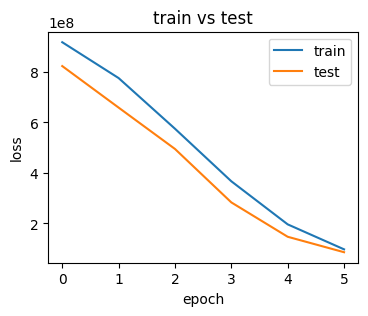

In [84]:
plt.figure(figsize=(4,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train vs test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Extracting the Embeddings from the Model and Attaching to DataFrame

We extract the embeddings from the trained model, convert them into DataFrames, and store them for further use.

In [85]:
embeddings_dfs = {}

for column in categorical_features:
    indices = le_dict[column]
    embeddings = {ind: model.get_layer(f'{column}_embedding').get_weights()[0][ind] for _, ind in indices.items()}
    embeddings_df = pd.DataFrame(embeddings).T.reset_index()
    embeddings_df = embeddings_df.rename(columns={'index': f'index_{column}'})
    embeddings_df.columns = [f'{column}_{i}' if i != f'index_{column}' else i for i in embeddings_df.columns]
    embeddings_dfs[column] = embeddings_df
    
# An example for the feature representaion in the Dataframe   
source_df =  embeddings_dfs['Total_stops']
source_df

,index_Total_stops,Total_stops_0,Total_stops_1
0,0,0.005115,-0.001081
1,1,0.019285,-0.023927
2,2,-0.273666,0.288761


In [62]:
# encoding the categorical values by le_dict - first encoding
original_dtf_c = original_dtf.copy()
for col in categorical_features:
    original_dtf_c[col] = original_dtf_c[col].map(le_dict[col
                                                  
min_date = original_dtf_c['Date_of_journey'].min()
original_dtf_c['Date_of_journey'] = (original_dtf_c['Date_of_journey'] - min_date).dt.total_seconds() / (24 * 60 * 60)

Now, we merge the encoded categorical features from the original dataframe with their corresponding embeddings extracted from the model, resulting in a final dataframe 'merged_dtf' containing both numerical and embedded representations of the categorical features.

In [63]:
merged_dtf = original_dtf_c.copy()
 
for column in categorical_features:
    embeddings_df = embeddings_dfs[column]
    merged_dtf = pd.merge(merged_dtf, embeddings_df, how='inner', left_on=column, right_on=f'index_{column}')
    merged_dtf.drop([column, f'index_{column}'], axis=1, inplace=True)
    
merged_dtf.head(3)

,Date_of_journey,Duration_in_hours,Advance_days,Fare,Journey_day_0,Journey_day_1,Journey_day_2,Journey_day_3,Airline_0,Airline_1,...,Total_stops_0,Total_stops_1,Arrival_0,Arrival_1,Destination_0,Destination_1,Destination_2,Destination_3,Month_0,Month_1
0,0.0,2.0833,1,5335,0.017971,0.031572,-0.041675,0.015025,-0.247156,-0.222814,...,-0.273666,0.288761,-0.000953,-0.008911,0.032115,-0.055032,0.037535,-0.035606,-0.00103,0.00047
1,0.0,2.3333,1,5899,0.017971,0.031572,-0.041675,0.015025,-0.261672,-0.182378,...,-0.273666,0.288761,0.029203,-0.006473,0.032115,-0.055032,0.037535,-0.035606,-0.00103,0.00047
2,0.0,2.1667,1,5801,0.017971,0.031572,-0.041675,0.015025,-0.273776,-0.206739,...,-0.273666,0.288761,0.029203,-0.006473,0.032115,-0.055032,0.037535,-0.035606,-0.00103,0.00047


### Running the baseline model with the Embedded Data

In [64]:
X = merged_dtf.drop(columns = 'Fare')
y = merged_dtf.Fare
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle = True)

baseline_model = xgb.XGBRegressor(objective="reg:squarederror")
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
statistics_measurements("baseline_model",y_test,y_pred)

baseline_model
R2 Score: 0.9527104334482284
Mean Absolute Perc Error: 0.128


We can see that using categorical embeddings improved the baseline model. So now, we'll test the best model with this dataFrame and see how accurate it is.

In [80]:
y_log = np.cbrt(y)
X_train, X_test, y_train, y_test = train_test_split(X,y_log, test_size=0.2, random_state=42, shuffle = True)

final_model = xgb.XGBRegressor(objective="reg:squarederror", **best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
statistics_measurements("Final model",y_test,y_pred)

Final model
R2 Score: 0.9806555376937645
Mean Absolute Perc Error: 0.025


We can see an improvement compared to the best model without the categorical embedding.

Now, lest analyze the final model with SHAP - we chose a asubset of the data since our data is big and takes too long to run.

In [75]:
subset_size = 1000
subset_indices = np.random.choice(merged_dtf.shape[0], size=subset_size, replace=False)
X_subset = merged_dtf.loc[subset_indices].drop(columns=['Fare'])
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_subset)

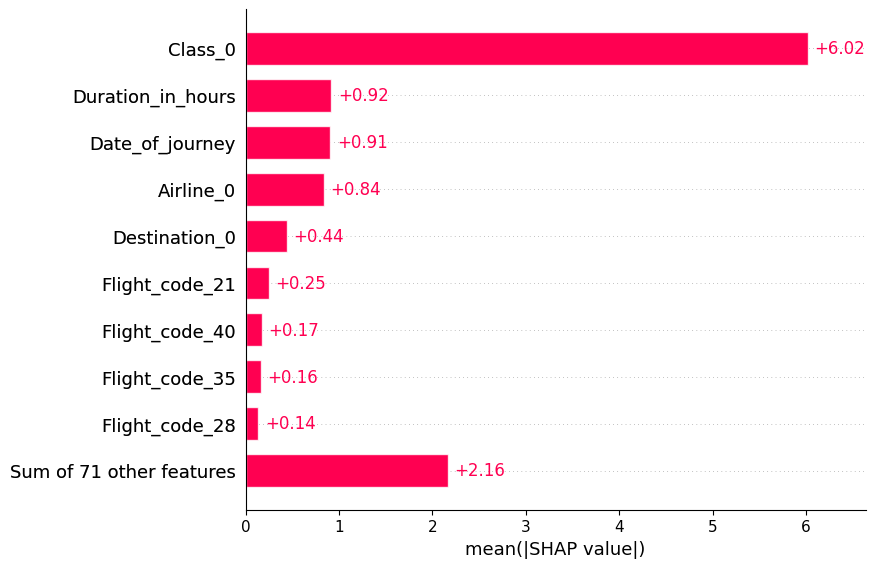

In [79]:
shap.plots.bar(shap_values)

### SHAP explanation

In our SHAP analysis of the final model, we found that the "class" feature still holds the most affect over flight price predictions. However, we noticed a notable shift in the importance of "duration in hours" and "date of journey" compared to the baseline model.
While "duration in hours" and "date of journey" were also significant in the baseline analysis, we observed a change in their relative importance in the final model. In the baseline, "date of journey" had more affect on the prediction than "duration in hours." However, in the final model, "duration in hours" now shares equal importance with "date of journey."

This knowledge empowers us to make informed decisions when planning flights, whether it's selecting the most opportune travel dates, or considering the duration of the flight, our newfound understanding leads us to smarter choices and better outcomes.

### why your pipeline is differ from other pipelines

Our flight price prediction pipeline stands out from others due to its unique combination of embedding techniques, hyperparameter tuning, and logarithmic transformation applied to the target variable. While some pipelines may focus solely on traditional modeling approaches, our innovative approach integrates advanced methods to effectively capture complex relationships in the data. 

## External resources

- [https://arxiv.org/abs/1604.06737](https://arxiv.org/abs/1604.06737)  
- [https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137)
